In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.activations import relu

2022-12-18 14:08:24.241475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Read in simulated data

In [2]:
BMI_X = pd.read_csv("simulatedBMIdata.csv")

In [3]:
print(BMI_X.shape)
print(BMI_X.columns)

(10000, 4)
Index(['Unnamed: 0', 'gender', 'height', 'mass'], dtype='object')


### Calculate Body Mass Index

In [4]:
BMI_Y = BMI_X["mass"] / BMI_X["height"]**2

In [5]:
#drop Gender and Index 
BMI_X = BMI_X[["mass","height"]]

In [6]:
print(BMI_X.shape)
print(BMI_X.columns)
print(BMI_Y.shape)

(10000, 2)
Index(['mass', 'height'], dtype='object')
(10000,)


### Split data into train and test sets

In [7]:
train_x,test_x,train_y,test_y = train_test_split(BMI_X,BMI_Y,test_size = .2,random_state = 42)

In [8]:
print(train_x.shape)

(8000, 2)


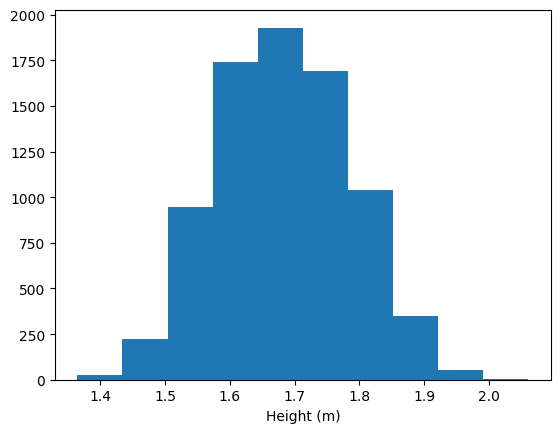

In [9]:
plt.hist(train_x["height"])
plt.xlabel("Height (m)")
plt.show()

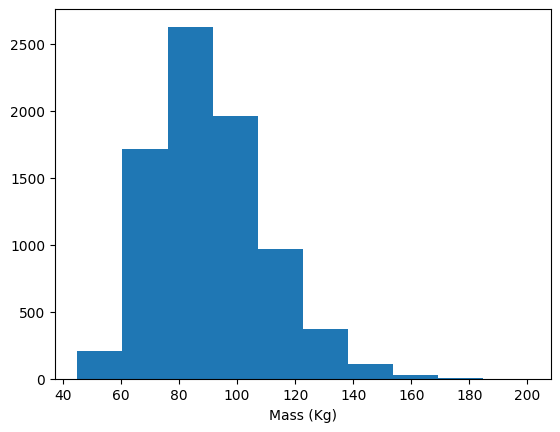

In [10]:
plt.hist(train_x["mass"])
plt.xlabel("Mass (Kg)")
plt.show()

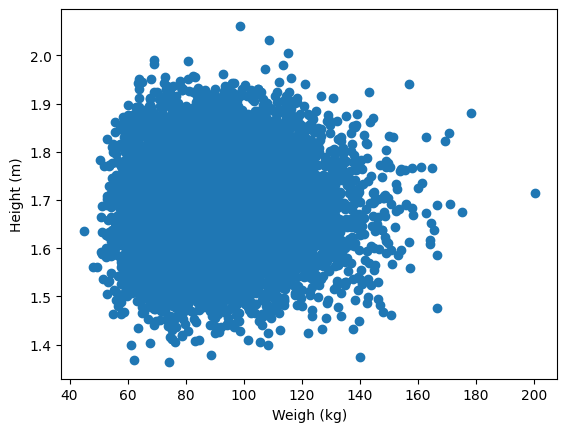

In [11]:
plt.scatter(train_x["mass"],train_x["height"])
plt.xlabel("Weigh (kg)")
plt.ylabel("Height (m)")
plt.show()

### Scale the input data

In [12]:
scaler = StandardScaler()
scaler.fit(train_x)

print(scaler.mean_)

train_x_scaled = scaler.transform(train_x)
test_x_scaled = scaler.transform(test_x)

[90.54705675  1.68345036]


#### Create another metric to track during training

In [13]:
def R_Squared(y_true, y_pred):
    from tensorflow.keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Train the Neural Network

In [14]:
model = Sequential()

model.add(Dense(16, activation=relu,input_shape = (2,)))
model.add(Dense(16, activation=relu))
model.add(Dense(1))

model.compile(optimizer = 'adam',loss = 'mean_squared_error',metrics=[R_Squared])

model.fit(
    x = train_x_scaled
    ,y = train_y
    ,batch_size = 32
    ,validation_data = (test_x_scaled, test_y)
    ,epochs = 50
)

Epoch 1/50


2022-12-18 14:08:35.904410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


250/250 [==============================] - 1s 2ms/step - loss: 847.8326 - R_Squared: -14.1652 - val_loss: 352.7710 - val_R_Squared: -5.4800
Epoch 2/50
250/250 [==============================] - 0s 910us/step - loss: 90.3924 - R_Squared: -0.6089 - val_loss: 27.1926 - val_R_Squared: 0.5003
Epoch 3/50
250/250 [==============================] - 0s 933us/step - loss: 18.8084 - R_Squared: 0.6688 - val_loss: 13.4122 - val_R_Squared: 0.7542
Epoch 4/50
250/250 [==============================] - 0s 871us/step - loss: 9.2520 - R_Squared: 0.8355 - val_loss: 6.6535 - val_R_Squared: 0.8779
Epoch 5/50
250/250 [==============================] - 0s 924us/step - loss: 4.6360 - R_Squared: 0.9171 - val_loss: 3.3994 - val_R_Squared: 0.9377
Epoch 6/50
250/250 [==============================] - 0s 895us/step - loss: 2.3987 - R_Squared: 0.9576 - val_loss: 1.7720 - val_R_Squared: 0.9675
Epoch 7/50
250/250 [==============================] - 0s 892us/step - loss: 1.2940 - R_Squared: 0.9770 - val_loss: 0.9828 - v

So our final fitted test data has a R Squared that is quite high.  What does this look like?

63/63 [==============================] - 0s 671us/step


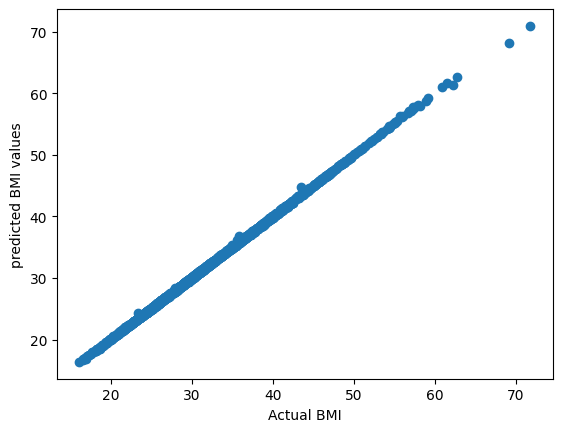

In [15]:
preds = model.predict(test_x_scaled)
plt.scatter(test_y,preds)
plt.xlabel("Actual BMI")
plt.ylabel("predicted BMI values")
plt.show()

The result is essentially linear.  That is, Fully Connected Neural Nets are able to replicate the transformation from scratch.

### Can the same neural net perform the same trick in the presence of noise?
Let's see.

Add noise variables.

In [17]:
n_noise_var = 14
n_obs_train = train_x.shape[0]
n_obs_test = test_x.shape[0]

In [18]:
train_noise_var = np.random.normal(size=n_obs_train*n_noise_var).reshape(n_obs_train,n_noise_var)
test_noise_var = np.random.normal(size=n_obs_test*n_noise_var).reshape(n_obs_test,n_noise_var)

In [19]:
train_x_scaled = np.concatenate((train_x_scaled,train_noise_var),axis = 1)
test_x_scaled = np.concatenate((test_x_scaled,test_noise_var),axis = 1)

In [20]:
print(train_x_scaled.shape)
print(test_x_scaled.shape)

(8000, 16)
(2000, 16)


### Estimate the same model with noise variables

In [21]:
model2 = Sequential()

model2.add(Dense(16, activation=relu,input_shape = (16,)))
model2.add(Dense(16, activation=relu))
model2.add(Dense(1))

model2.compile(optimizer = 'adam',loss = 'mean_squared_error',metrics=[R_Squared])

model2.fit(
    x = train_x_scaled
    ,y = train_y
    ,batch_size = 32
    ,validation_data = (test_x_scaled, test_y)
    ,epochs = 50
)

Epoch 1/50
250/250 [==============================] - 1s 1ms/step - loss: 706.5052 - R_Squared: -11.5634 - val_loss: 157.1047 - val_R_Squared: -1.8901
Epoch 2/50
250/250 [==============================] - 0s 1ms/step - loss: 50.5905 - R_Squared: 0.0991 - val_loss: 30.8074 - val_R_Squared: 0.4185
Epoch 3/50
250/250 [==============================] - 0s 1ms/step - loss: 25.0291 - R_Squared: 0.5490 - val_loss: 24.4888 - val_R_Squared: 0.5378
Epoch 4/50
250/250 [==============================] - 0s 1ms/step - loss: 20.4841 - R_Squared: 0.6285 - val_loss: 19.9767 - val_R_Squared: 0.6237
Epoch 5/50
250/250 [==============================] - 0s 985us/step - loss: 16.7717 - R_Squared: 0.6958 - val_loss: 16.4204 - val_R_Squared: 0.6914
Epoch 6/50
250/250 [==============================] - 0s 1ms/step - loss: 13.7355 - R_Squared: 0.7517 - val_loss: 13.3562 - val_R_Squared: 0.7498
Epoch 7/50
250/250 [==============================] - 0s 1ms/step - loss: 11.1661 - R_Squared: 0.7966 - val_loss: 10.

63/63 [==============================] - 0s 682us/step


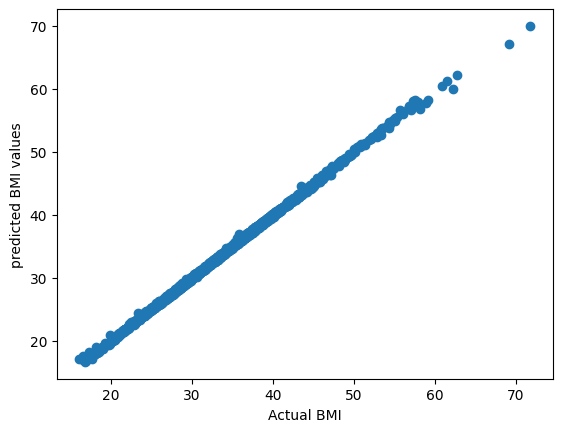

In [22]:
preds_scaled = model2.predict(test_x_scaled)
plt.scatter(test_y,preds_scaled)
plt.xlabel("Actual BMI")
plt.ylabel("predicted BMI values")
plt.show()

The noise variables have no effect on prediction on the test set.  That is, the model learns to ignore all of the noise variables and make predictions on data is doesn't see.

## What's the big deal?
Okay.  A neural net is capable of replicating an entirely deterministic transformation.  ***Why should we care?***